## Loading Data and Packages

In [1]:
import pandas as pd
import numpy as np
import os, timeit
from scipy.stats import randint, uniform

from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import metrics
from sklearn import tree, decomposition
from sklearn import ensemble
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 42            # setting random seed
np.random.seed(seed)

In [3]:
%load_ext memory_profiler

In [4]:
data = pd.read_csv(r'E:\Coding\Summer 2023\supervised learning bank data\data\bank-additional-full.csv', sep=';', header=0)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Checking for missing values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

From documentation of the data:    
* *pdays:* number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)    
* *duration:* last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [6]:
data[data['pdays'] == 999].shape[0]/data.shape[0]

0.9632174419733903

In [7]:
data['pdays'] = data['pdays'].astype('category')
data.drop(['duration'], axis=1, inplace=True)

Converting 'pdays' from int64 to categorical and dropping the 'duration' attribute.

Note that there is a high imbalance in the data

In [8]:
# The baseline accuracy is 88.7% if we predict yes for all inputs.
# It shows imbalance in data.

{"YES": round(np.mean(data["y"] == "yes"), 3), "NO": np.round(np.mean(data["y"] == "no"), 3)}

{'YES': 0.113, 'NO': 0.887}

In [9]:
# Selecting the Categorical attributes
catvar = data.select_dtypes(include=['object','category']).astype('category').columns.values.tolist()
catvar = [i for i in catvar if i not in ['month','education','day_of_week','y']]

# Selecting the Numeric Variables
numvar = data._get_numeric_data().columns.values.tolist()

---

## Preprocessing the Data

In [10]:
# Splitting Data before any sort of prepocessing to avoid any form of data leakage.
X = data.drop('y', axis=1).copy(deep = True)
Y = data["y"].copy(deep = True)

#One hot encoding
cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X_encoded = pd.get_dummies(X, cols)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, random_state=seed, stratify=Y)

## Utility Functions

In [11]:
def result_disp(model, X_train, X_test, y_train, y_test, name):
    y_pred = model.predict(X_train)
    print('\nTraining Data Scores:')
    print('Precision: {:0.6f}'.format(metrics.precision_score(y_train, y_pred, pos_label='yes')))
    print('Recall: {:0.6f}'.format(metrics.recall_score(y_train, y_pred, pos_label='yes')))
    print('F-Score: {:0.6f}'.format(metrics.f1_score(y_train, y_pred, pos_label='yes')))
    print('Accuracy: {:0.6f}'.format(metrics.accuracy_score(y_train, y_pred)))
    
    y_pred = model.predict(X_test)
    print('\nTest Data Scores:')
    print('Precision: {:0.6f}'.format(metrics.precision_score(y_test, y_pred, pos_label='yes')))
    print('Recall: {:0.6f}'.format(metrics.recall_score(y_test, y_pred, pos_label='yes')))
    print('F-Score: {:0.6f}'.format(metrics.f1_score(y_test, y_pred, pos_label='yes')))
    print('Accuracy: {:0.6f}\n\n'.format(metrics.accuracy_score(y_test, y_pred)))

    predictions = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, predictions, labels=['yes', 'no'])
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['yes', 'no'])
    disp.plot()
    plt.show()

# Naive Bayes

## Gaussian Naive Bayes

In [21]:
model_nb = GaussianNB()
model_nb.fit(X_train,y_train)

GaussianNB()

In [22]:
print("Naive Bayes score: ",model_nb.score(X_test, y_test))

Naive Bayes score:  0.8878314072059823


### Feature Selection using Kbest algorithm

In [23]:
X_cat = X.select_dtypes(include=['object', 'category'])
X_num = X.select_dtypes(exclude=['object', 'category'])

**For categorical features**

In [24]:
#label encoding
cols = X_cat.columns
X_cat_encoded = X_cat.copy(deep=True)
X_cat_encoded[cols] = X_cat[cols].apply(LabelEncoder().fit_transform)

In [25]:
#split train test
X_fs_train, X_fs_test, y_fs_train, y_fs_test = train_test_split(X_cat_encoded, Y, random_state=42, stratify=Y)

In [26]:
#feature selection
from sklearn.feature_selection import chi2
test = SelectKBest(score_func=chi2, k='all')
fit = test.fit(X_fs_train, y_fs_train)
np.set_printoptions(precision=3)
print(fit.scores_)

[6.457e+01 2.410e+01 1.210e+02 2.308e+02 2.882e+00 1.111e-01 3.925e+02
 1.027e+00 3.209e+00 1.893e+03 7.388e+01]


<BarContainer object of 11 artists>

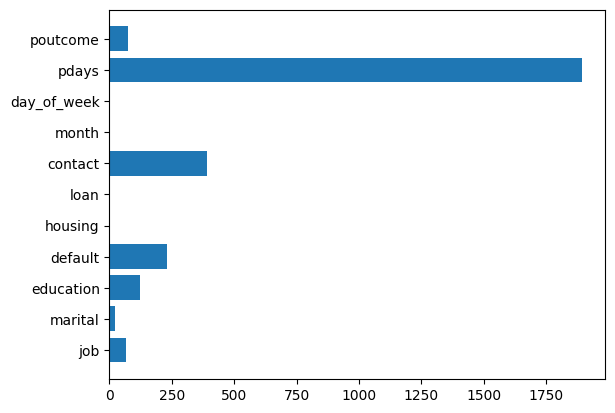

In [27]:
plt.barh(X_fs_train.columns,fit.scores_)

**For numerical features**

[  25.102  132.207 1728.892 2859.746  525.952   89.605 3080.121 4277.643]


<BarContainer object of 8 artists>

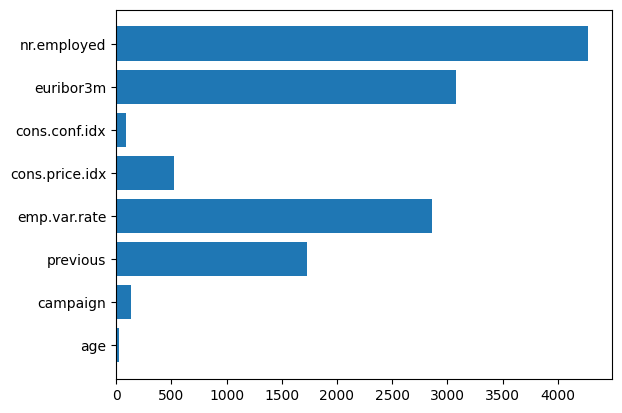

In [28]:
#split train test
X_fs1_train, X_fs1_test, y_fs1_train, y_fs1_test = train_test_split(X_num, Y, random_state=42, stratify=Y)

#feature selection
from sklearn.feature_selection import f_classif
test = SelectKBest(score_func=f_classif, k='all')
fit = test.fit(X_fs1_train, y_fs1_train)
np.set_printoptions(precision=3)
print(fit.scores_)

plt.barh(X_fs1_train.columns,fit.scores_)

**Training model after feature selection**

In [29]:
#removed less important features from X_t1
dummy_X = X.drop(columns=["cons.conf.idx","campaign","age","cons.price.idx","day_of_week","month","loan", "housing"])

#One hot encoding of dummy_X
cols = dummy_X.select_dtypes(include=['object', 'category']).columns.tolist()
X_encoded = pd.get_dummies(dummy_X, cols)

#Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, random_state=42, stratify=Y)

#training model
from sklearn.naive_bayes import GaussianNB
model_t1 = GaussianNB()
model_t1.fit(X_train,y_train)

#testing model on entire test set (with all features)
print("Naive Bayes accuracy: ",model_t1.score(X_test, y_test))
print(metrics.classification_report(y_test, model_t1.predict(X_test)))

Naive Bayes accuracy:  0.89501796639798
              precision    recall  f1-score   support

          no       0.91      0.98      0.94      9137
         yes       0.60      0.20      0.30      1160

    accuracy                           0.90     10297
   macro avg       0.75      0.59      0.62     10297
weighted avg       0.87      0.90      0.87     10297



### Hyperparameter tuning

**Grid Search CV was used for hyperparameter tuning on the data obtained after feature selection**

In [30]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [31]:
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb)

In [32]:
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)
y_pred = nbModel_grid.predict(X_test)

GaussianNB()


In [33]:
print("Accuracy score: ", metrics.accuracy_score(y_test, y_pred))

Accuracy score:  0.89501796639798


In [34]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.91      0.98      0.94      9137
         yes       0.60      0.20      0.30      1160

    accuracy                           0.90     10297
   macro avg       0.75      0.59      0.62     10297
weighted avg       0.87      0.90      0.87     10297




Training Data Scores:
Precision: 0.594340
Recall: 0.217241
F-Score: 0.318182
Accuracy: 0.895115

Test Data Scores:
Precision: 0.602067
Recall: 0.200862
F-Score: 0.301228
Accuracy: 0.895018




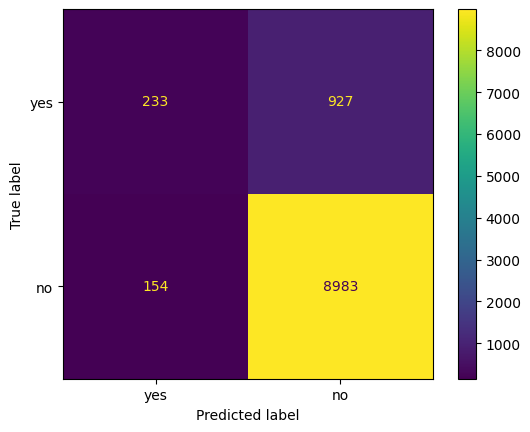

In [35]:
# Final Results

result_disp(nbModel_grid, X_train, X_test, y_train, y_test, 'Naive Bayes')

# Decision Tree

In [17]:
# Base Classifier

dec_tree = tree.DecisionTreeClassifier(ccp_alpha = 0.0002, random_state=seed)
bg_clf = dec_tree.fit(X_train,y_train)

In [18]:
print(metrics.classification_report(y_test, bg_clf.predict(X_test)))

              precision    recall  f1-score   support

          no       0.91      0.98      0.95      9137
         yes       0.68      0.26      0.38      1160

    accuracy                           0.90     10297
   macro avg       0.80      0.62      0.66     10297
weighted avg       0.89      0.90      0.88     10297




Training Data Scores:
Precision: 0.646383
Recall: 0.274713
F-Score: 0.385562
Accuracy: 0.901363

Test Data Scores:
Precision: 0.678492
Recall: 0.263793
F-Score: 0.379888
Accuracy: 0.902981




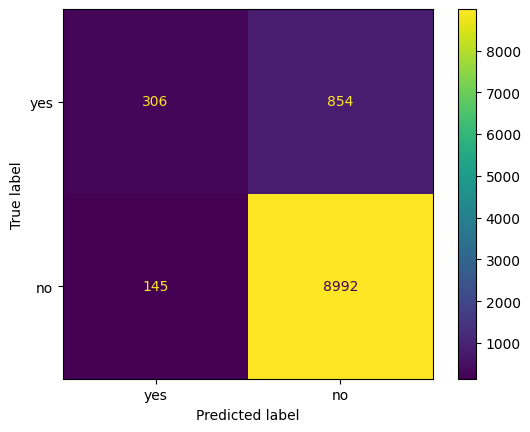

In [19]:
# Final Results
result_disp(bg_clf, X_train, X_test, y_train, y_test, 'Decision Tree')

## Random Forest Classifier

**Without any improvements**

In [13]:
start = timeit.default_timer()
rf_clf = RandomForestClassifier(random_state=seed)
%memit rf_clf = rf_clf.fit(X_train, y_train)
stop = timeit.default_timer()
runtime = stop - start
print("Random Forest Classifier runtime: {0:.2f} seconds".format(runtime))

peak memory: 362.40 MiB, increment: 83.66 MiB
Random Forest Classifier runtime: 10.44 seconds


In [17]:
print(metrics.classification_report(y_test, rf_clf.predict(X_test)))

              precision    recall  f1-score   support

          no       0.91      0.97      0.94      9137
         yes       0.55      0.27      0.36      1160

    accuracy                           0.89     10297
   macro avg       0.73      0.62      0.65     10297
weighted avg       0.87      0.89      0.88     10297




Training Data Scores:
Precision: 0.992643
Recall: 0.969253
F-Score: 0.980808
Accuracy: 0.995727

Test Data Scores:
Precision: 0.546573
Recall: 0.268103
F-Score: 0.359746
Accuracy: 0.892493




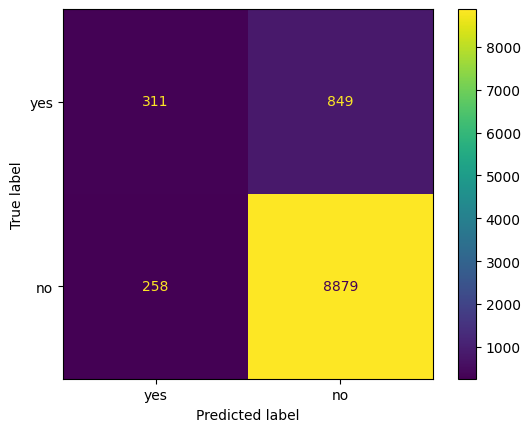

In [15]:
# Final Results

result_disp(rf_clf, X_train, X_test, y_train, y_test, 'Random Forest')

In [19]:
print("Random Forest Classifier accuracy: ", rf_clf.score(X_test, y_test)*100, "%")

Random Forest Classifier accuracy:  89.24929591143052 %


## Hyperparameter tuning with grid search CV

We're going to use 5 fold cross validation to get the best hyperparameter as Decision tress are prone to overfitting.

In [20]:
params = {'max_depth': [1,2,4,5],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2,3,4,5]}

In [21]:
start = timeit.default_timer()
clf_dt = RandomForestClassifier(random_state=seed)
clf_dt = GridSearchCV(estimator= clf_dt, param_grid=params, verbose=False, cv = 5)
%memit clf_dt = clf_dt.fit(X_train, y_train)
stop = timeit.default_timer()
runtime = stop - start
print("Random Forest Classifier with Grid Search CV runtime: {0:.2f} seconds".format(runtime))

peak memory: 333.42 MiB, increment: 34.64 MiB
Random Forest Classifier with Grid Search CV runtime: 501.06 seconds


In [24]:
print(metrics.classification_report(y_test, clf_dt.predict(X_test)))

              precision    recall  f1-score   support

          no       0.90      0.99      0.95      9137
         yes       0.76      0.17      0.27      1160

    accuracy                           0.90     10297
   macro avg       0.83      0.58      0.61     10297
weighted avg       0.89      0.90      0.87     10297




Training Data Scores:
Precision: 0.719484
Recall: 0.176149
F-Score: 0.283010
Accuracy: 0.899453

Test Data Scores:
Precision: 0.760784
Recall: 0.167241
F-Score: 0.274205
Accuracy: 0.900262




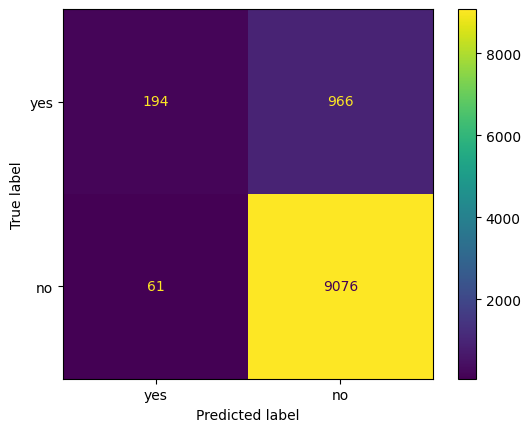

In [25]:
# Final Results

result_disp(clf_dt, X_train, X_test, y_train, y_test, 'Random Forest with Grid Search CV')

In [26]:
print("Random Forest with Grid Search CV accuracy: ",clf_dt.score(X_test, y_test)*100, "%")

Random Forest with Grid Search CV accuracy:  90.02622122948432 %


## Boosting

In [29]:
start = timeit.default_timer()
clf_b = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1), random_state=seed)
%memit clf_b = clf_dt.fit(X_train, y_train)
stop = timeit.default_timer()
runtime = stop - start
print("Boosting with decision stumps runtime: {0:.2f} seconds".format(runtime))

peak memory: 333.84 MiB, increment: 37.12 MiB
Boosting with decision stumps runtime: 415.34 seconds


In [31]:
print(metrics.classification_report(y_test, clf_b.predict(X_test)))

              precision    recall  f1-score   support

          no       0.90      0.99      0.95      9137
         yes       0.76      0.17      0.27      1160

    accuracy                           0.90     10297
   macro avg       0.83      0.58      0.61     10297
weighted avg       0.89      0.90      0.87     10297




Training Data Scores:
Precision: 0.719484
Recall: 0.176149
F-Score: 0.283010
Accuracy: 0.899453

Test Data Scores:
Precision: 0.760784
Recall: 0.167241
F-Score: 0.274205
Accuracy: 0.900262




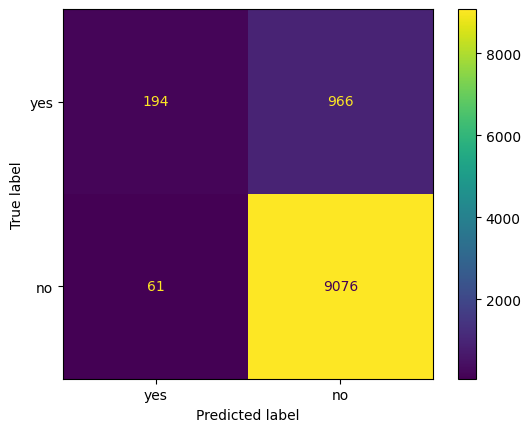

In [32]:
# Final Results

result_disp(clf_b, X_train, X_test, y_train, y_test, 'Boosting with decision stumps')

In [33]:
print("Boosting with decision stumps accuracy: ",clf_b.score(X_test, y_test)*100, "%")

Boosting with decision stumps accuracy:  90.02622122948432 %


### Hyperparameter tuning with grid search CV

We're going to use 5 fold cross validation to get the best hyperparameter as Decision tress are prone to overfitting.

In [12]:
params = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1)],
    'n_estimators': [2, 5, 10, 20, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 0.8],
    'algorithm': ['SAMME', 'SAMME.R']
}

In [13]:
start = timeit.default_timer()
clf_dt = AdaBoostClassifier(random_state=42)
clf_dt = GridSearchCV(estimator= clf_dt, param_grid=params, verbose=False, cv = 5)
%memit clf_dt = clf_dt.fit(X_train, y_train)
stop = timeit.default_timer()
runtime = stop - start
print("Boosting with decision stumps with Grid Search CV runtime: {0:.2f} seconds".format(runtime))

peak memory: 245.95 MiB, increment: 37.71 MiB
Boosting with decision stumps with Grid Search CV runtime: 920.05 seconds


In [14]:
print(metrics.classification_report(y_test, clf_dt.predict(X_test)))

              precision    recall  f1-score   support

          no       0.91      0.99      0.95      9137
         yes       0.73      0.19      0.31      1160

    accuracy                           0.90     10297
   macro avg       0.82      0.59      0.63     10297
weighted avg       0.89      0.90      0.87     10297




Training Data Scores:
Precision: 0.681996
Recall: 0.200287
F-Score: 0.309640
Accuracy: 0.899388

Test Data Scores:
Precision: 0.730519
Recall: 0.193966
F-Score: 0.306540
Accuracy: 0.901136




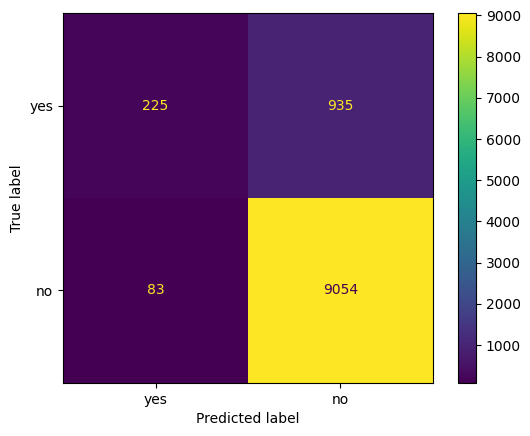

In [15]:
# Final Results

result_disp(clf_dt, X_train, X_test, y_train, y_test, 'Boosting with decision stumps with Grid Search CV')

In [16]:
print("Boosting with decision stumps with Grid Search CV accuracy: ",clf_dt.score(X_test, y_test)*100, "%")

Boosting with decision stumps with Grid Search CV accuracy:  90.11362532776536 %
